# Ejercicio de regresión


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

# 1. Análisis exploratorio

Vamos a trabajar con datos de fuga de una compañía telefónica. El objetivo es predecir cuándo los clientes van a abandonar la compañía.

<div class = "alert alert-success">
**EJERCICIO**: Cargue los datos *churn.csv* y realice un primer análisis de los datos cargados
</div>

<div class = "alert alert-success">
**EJERCICIO**: Este problema está desbalanceado, calcule el ratio de desbalanceo
</div>

In [3]:
data = pd.read_csv('diamonds.csv',sep=',',decimal='.')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
filas,columnas=data.shape
print("Filas=",filas,", Columnas=",columnas)

Filas= 53940 , Columnas= 11


In [5]:
ejercicio1_type=data.dtypes.to_frame(name='tipo')
print("Tipos de variables:\n",pd.concat([ejercicio1_type,data.astype('object').describe().transpose()], axis=1))

Tipos de variables:
                tipo  count unique    top   freq
Unnamed: 0    int64  53940  53940  53940      1
carat       float64  53940    273    0.3   2604
cut          object  53940      5  Ideal  21551
color        object  53940      7      G  11292
clarity      object  53940      8    SI1  13065
depth       float64  53940    184     62   2239
table       float64  53940    127     56   9881
price         int64  53940  11602    605    132
x           float64  53940    554   4.37    448
y           float64  53940    552   4.34    437
z           float64  53940    375    2.7    767


In [6]:
print(data.describe())

         Unnamed: 0         carat         depth         table         price  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean   26970.500000      0.797940     61.749405     57.457184   3932.799722   
std    15571.281097      0.474011      1.432621      2.234491   3989.439738   
min        1.000000      0.200000     43.000000     43.000000    326.000000   
25%    13485.750000      0.400000     61.000000     56.000000    950.000000   
50%    26970.500000      0.700000     61.800000     57.000000   2401.000000   
75%    40455.250000      1.040000     62.500000     59.000000   5324.250000   
max    53940.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y             z  
count  53940.000000  53940.000000  53940.000000  
mean       5.731157      5.734526      3.538734  
std        1.121761      1.142135      0.705699  
min        0.000000      0.000000      0.000000  
25%        4.710000      4.720000     

In [7]:
print("No missing data:\n",data.isnull().sum())

No missing data:
 Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64


In [8]:
#Variables categóricas y numéricas

var_num=['price','carat','depth','table','x','y','z']
var_cat=['cut','color','clarity']

In [9]:
###Get all categories from categorical variables 

for col in var_cat:
    results=data.groupby(col).agg({'price':['count','mean']}).sort_values([('price', 'count')],ascending=False)
    results.columns=results.columns.droplevel(0)
    results.columns=['count','mean']
    print("Unique",col,"\n",results)
#No categories "unknown"

Unique cut 
            count         mean
cut                          
Ideal      21551  3457.541970
Premium    13791  4584.257704
Very Good  12082  3981.759891
Good        4906  3928.864452
Fair        1610  4358.757764
Unique color 
        count         mean
color                    
G      11292  3999.135671
E       9797  3076.752475
F       9542  3724.886397
H       8304  4486.669196
D       6775  3169.954096
I       5422  5091.874954
J       2808  5323.818020
Unique clarity 
          count         mean
clarity                    
SI1      13065  3996.001148
VS2      12258  3924.989395
SI2       9194  5063.028606
VS1       8171  3839.455391
VVS2      5066  3283.737071
VVS1      3655  2523.114637
IF        1790  2864.839106
I1         741  3924.168691


##  1.1 preprocesamiento de variables

Si escribimos *data.dtypes* nos indica el tipo de las variables de nuestro dataframe. Vemos que tenemos variables categóricas que tenemos que codificar. 

<div class = "alert alert-success">
**EJERCICIO**: Elimine la variable *phone number* y codifique las variables categóricas.
</div>

In [10]:
if 'Unnamed: 0' in data.columns:
    data=data.drop(['Unnamed: 0'], axis=1)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [11]:
import category_encoders as ce
ordinal_cols_mapping = [
    {"col":"cut","mapping": [('Fair',0),('Good',1),('Very Good',2), ('Premium',3), ('Ideal',4)]},
    {"col":"color","mapping": [('J',0),('I',1),('H',2), ('G',3), ('F',4), ('E',5), ('D',6)]},
    {"col":"clarity","mapping": [('I1',0),('SI2',1),('SI1',2), ('VS2',3), ('VS1',4), ('VVS2',5), ('VVS1',6), ('IF',7)]},
]

encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping,return_df = True)  
data = encoder.fit_transform(data)

for col in var_cat:
    results=data.groupby(col).agg({'price':['count','mean']}).sort_values([('price', 'count')],ascending=False)
    results.columns=results.columns.droplevel(0)
    results.columns=['count','mean']
    print("Unique",col,"\n",results)


Unique cut 
      count         mean
cut                    
4    21551  3457.541970
3    13791  4584.257704
2    12082  3981.759891
1     4906  3928.864452
0     1610  4358.757764
Unique color 
        count         mean
color                    
3      11292  3999.135671
5       9797  3076.752475
4       9542  3724.886397
2       8304  4486.669196
6       6775  3169.954096
1       5422  5091.874954
0       2808  5323.818020
Unique clarity 
          count         mean
clarity                    
2        13065  3996.001148
3        12258  3924.989395
1         9194  5063.028606
4         8171  3839.455391
5         5066  3283.737071
6         3655  2523.114637
7         1790  2864.839106
0          741  3924.168691


<div class = "alert alert-success">
**EJERCICIO**: Represente el histograma de las variable con distintos colores para cada clase.
</div>

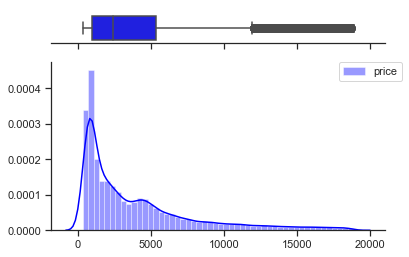

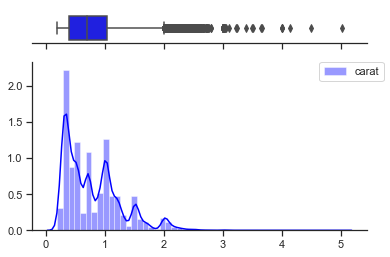

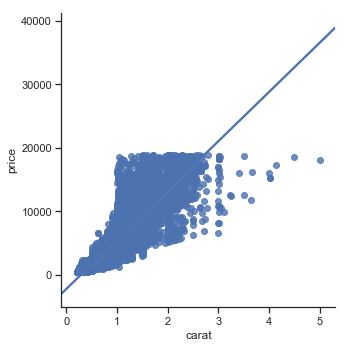

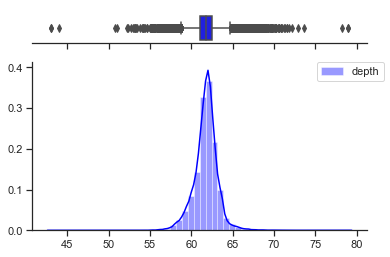

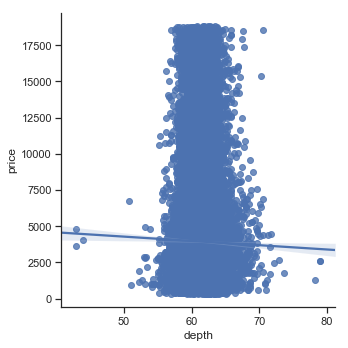

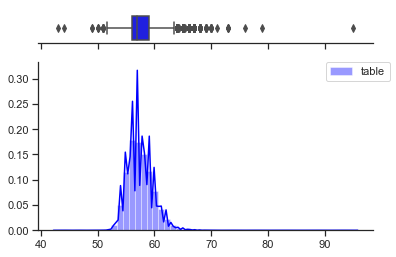

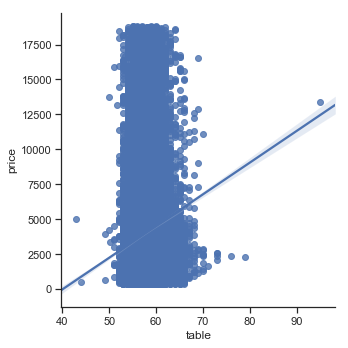

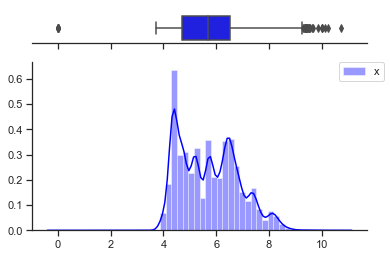

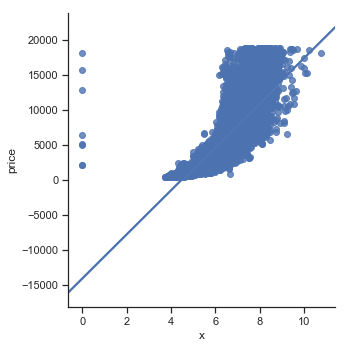

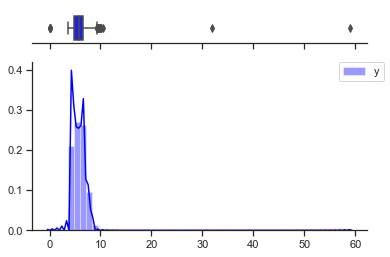

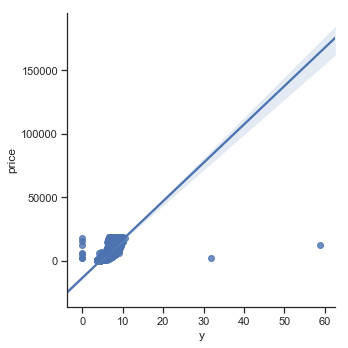

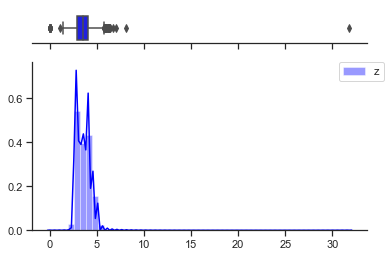

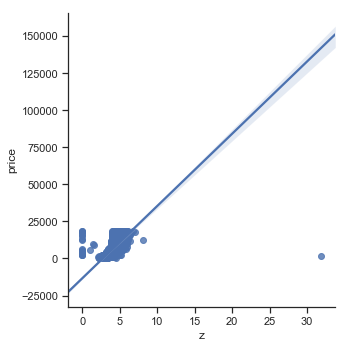

In [12]:
#Gráficos para observar las variables numéricas e identificar rápidamente los outliers
sns.set(style="ticks")

def boxplots(data_input):
    X=data[var_num].values
    for i in range(0, X.shape[1]):

        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                            gridspec_kw={"height_ratios": (.15, .85)})

        sns.boxplot(X[:,i], ax=ax_box,color='blue')
        sns.distplot(X[:,i], ax=ax_hist, label=data[var_num].columns[i],color='blue')

        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
        #ax_hist.legend(etiqueta)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
        if (i>0):
            sns.lmplot(data_input[var_num].columns[i],data_input[var_num].columns[0], data=data_input)

boxplots(data[var_num])


              carat           cut         color       clarity         depth  \
count  50605.000000  50605.000000  50605.000000  50605.000000  50605.000000   
mean       0.729915      2.917953      3.449047      3.080486     61.745912   
std        0.390512      1.108166      1.691880      1.648117      1.352471   
min        0.200000      0.000000      0.000000      0.000000     56.000000   
25%        0.380000      2.000000      2.000000      2.000000     61.100000   
50%        0.700000      3.000000      3.000000      3.000000     61.800000   
75%        1.010000      4.000000      5.000000      4.000000     62.500000   
max        2.770000      4.000000      6.000000      7.000000     67.500000   

              table         price             x             y             z  
count  50605.000000  50605.000000  50605.000000  50605.000000  50605.000000  
mean      57.416581   3232.363087      5.597105      5.599997      3.456410  
std        2.205102   2874.047500      1.005171      0

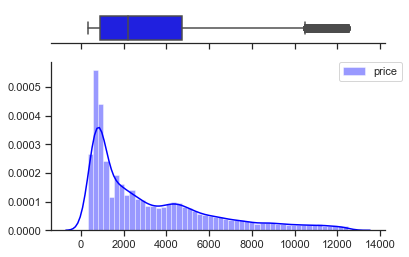

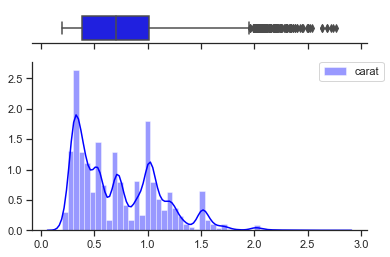

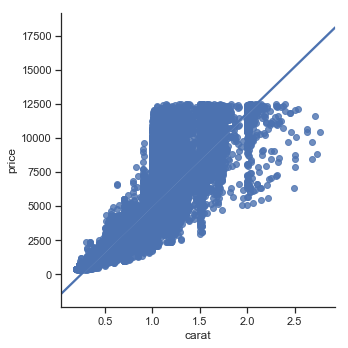

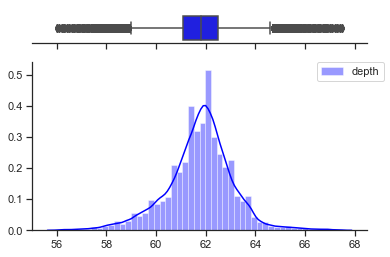

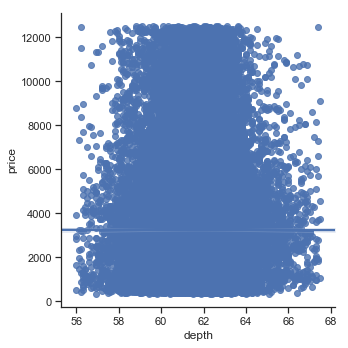

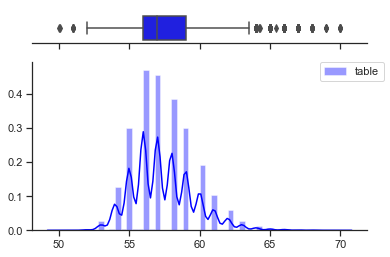

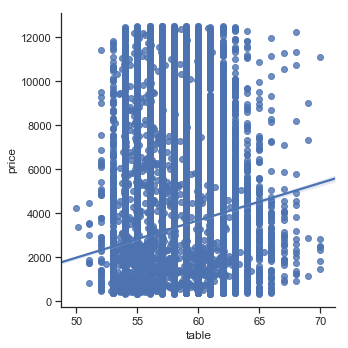

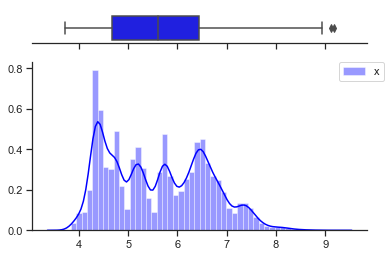

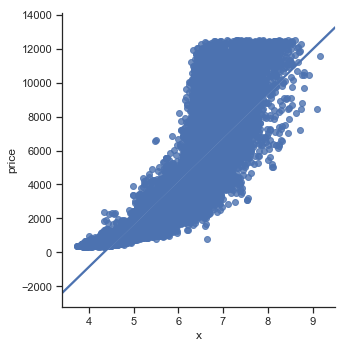

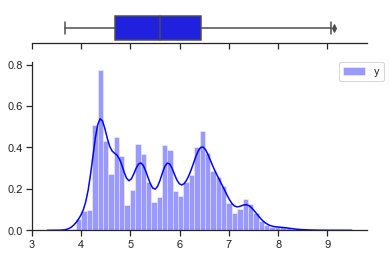

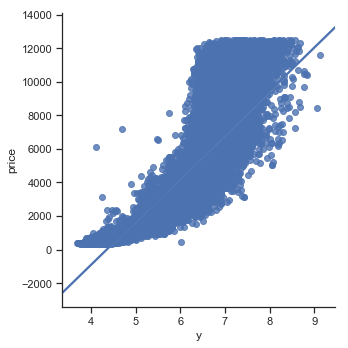

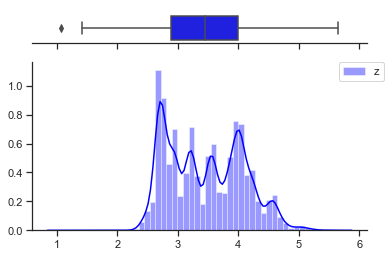

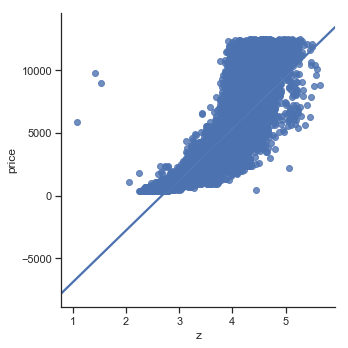

In [13]:
#Eliminación de outliers
filtro_price = data.price < 12500
data = data[filtro_price]
filtro_carat = data.carat < 3
data = data[filtro_carat]
filtro_depth = data.depth >=56 
data = data[filtro_depth]
filtro_depth = data.depth <=67.5
data = data[filtro_depth]
filtro_table = data.table >=50 
data = data[filtro_table]
filtro_table = data.table <=70 
data = data[filtro_table]
filtro_x = data.x >0 
data = data[filtro_x]
filtro_y = data.y <20 
data = data[filtro_y]
filtro_z = data.z >0 
data = data[filtro_z]
filtro_z = data.z <20 
data = data[filtro_z]

print(data.describe())
boxplots(data[var_num])

#Los gráficos se ven mejor

No se rechaza H0: Precio sigue una dist. normal.  KstestResult(statistic=0.9999999964150826, pvalue=0.0)


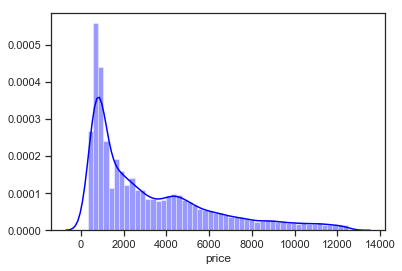

In [50]:
sns.distplot(data['price'], label='price',color='blue')
print("Se rechaza H0: Precio sigue una dist. normal. ",
      stats.kstest(np.log(data['price']), 'norm'))

No se rechaza H0: Logaritmo de precio sigue una dist. normal.  KstestResult(statistic=0.9999999964150826, pvalue=0.0)


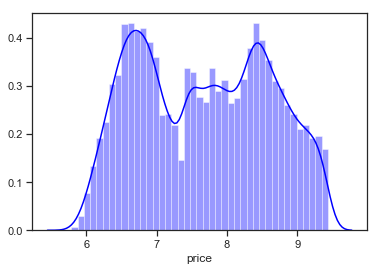

In [48]:
#sns.distplot(data['price'], label='price',color='blue')
sns.distplot(np.log(data['price']), label='price',color='blue')
print("Se rechaza H0: Logaritmo de precio sigue una dist. normal. ",
      stats.kstest(np.log(data['price']), 'norm'))

## 1.2 Correlación entre variables

<div class = "alert alert-success">
**EJERCICIO**: Represente el mapa de correlación entre variables
</div>

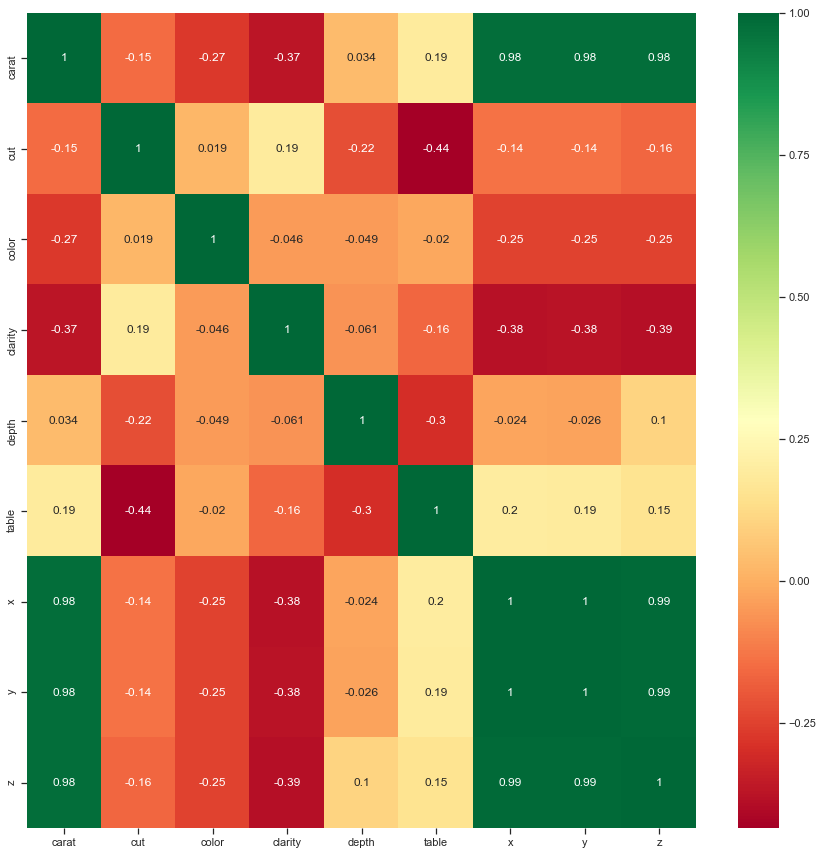

In [15]:
# plot the heatmap
top_corr_features = data.columns.drop(['price'])
plt.figure(figsize=(15,15))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#Las variables x, y, z tienen altísima correlación entre ellas y además están correlacionadas 
#con carat por lo que elimino las 3

En clasificación, variables correlacionadas no afectan al proceso de clasificación. Sin embargo, dada la correlación extrema y con el objetivo de eliminar variables poco informativas, podemos eliminar algunas columnas.

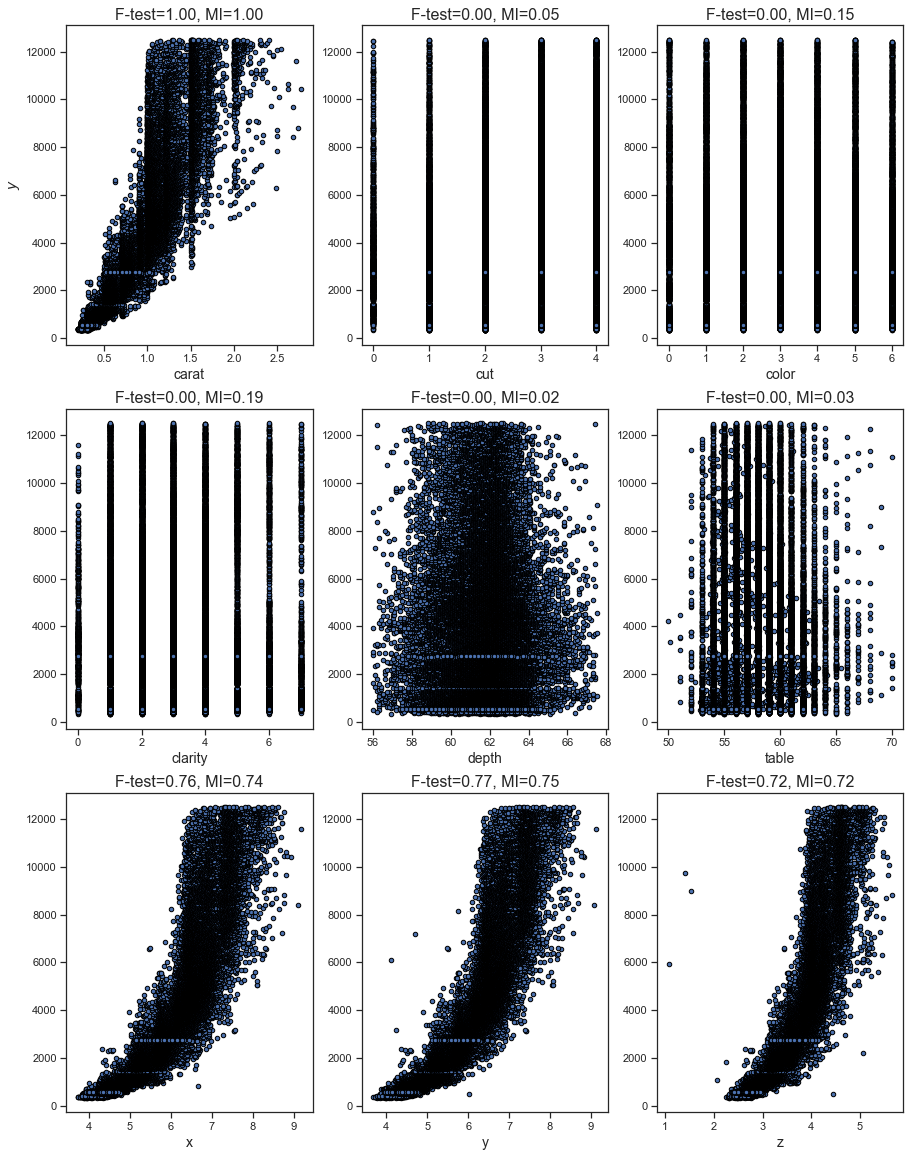

In [16]:
#filtrado
from sklearn.feature_selection import f_regression, mutual_info_regression

X = data[data.columns.drop('price')].values
y = data['price'].values
name_var=data.columns.drop('price')

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(15, 20))
for i in range(0,X.shape[1]):
    plt.subplot(3, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel(name_var[i], fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()

#Según las técnicas de filtrado sólo habría que quedarse con la variable carat y excluir las demás.

In [17]:
#x,y,z are highly correlated with carat, therefore can be excluded
columns_to_drop = ['x','y','z']

# 2. Métricas en regresión

Vamos a representar la matriz de confusión, y a partir de ella calcular distintas métricas. Para ello, comencemos un clasificador sencillo: regresión logística.

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# preparamos los datos

columns_to_drop.append('price')
features = data.columns.drop(columns_to_drop)

X = data[features].values
y = data['price'].values


# PASO 1: Obtengo el split train/test antes de estandarizar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  random_state=0)#stratify=y is for classification?

degree=10

# features
#Genero un poliniomio de grado 10 para la variable carat
poly    = PolynomialFeatures(degree) # generamos x^j
V_train = poly.fit_transform(X_train[:,:1])
V_test  = poly.fit_transform(X_test[:,:1])

#Añado el polinomio al conjunto inicial de variables independientes
X_train = np.append(X_train,V_train[:,1:],axis=1)
X_test  = np.append(X_test,V_test[:,1:],axis=1)

#Obtengo la interacción entre carat y clarity
poly_int = PolynomialFeatures(interaction_only=True)
W_train = poly_int.fit_transform(X_train[:, [1, 4]])
W_test  = poly_int.fit_transform(X_test[:, [1, 4]])

#Añado la interacción entre carat y clarity a las variables independientes
X_train = np.append(X_train,W_train[:,3:],axis=1)
X_test  = np.append(X_test,W_test[:,3:],axis=1)

#Estandarizo las variables independientes
scaler_xtr  = StandardScaler().fit(X_train)
Xs_train = scaler_xtr.transform(X_train)
Xs_test  = scaler_xtr.transform(X_test)

#Estandarizo la variable dependiente
scaler_ytr = StandardScaler().fit(y_train.reshape(-1, 1))
ys_train=scaler_ytr.transform(y_train.reshape(-1, 1)).ravel()
ys_test=scaler_ytr.transform(y_test.reshape(-1, 1)).ravel()

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Proporción train:%0.3f'%np.mean(ys_train))
print('Proporción test: %0.3f'%np.mean(ys_test))

Datos train:  (37953, 17)
Datos test:   (12652, 17)
Proporción train:0.000
Proporción test: 0.013


Las variables explicativas quedan así:
x1 : carat
x2 : cut
x3 : color
x4 : clarity
x5 : depth
x6 : table
x7 : carat^2
x8 : carat^3
x9 : carat^4
x10: carat^5
x11: carat^6
x12: carat^7
x13: carat^8
x14: carat^9
x15: carat^10
x16: Interacción entre carat y clarity. Son las 2 variables con mayora MI

# 2.1 Regularización sobre algoritmos de regresión.


En primer lugar, ajustamos un modelo (regresión lineal) muy complejo sobre estos datos, de la forma:

$$f_{\omega}(x) = \omega_0 + \sum_{j=1}^{10}\omega_j x^j$$

el cual tiene 10 coeficientes ($\omega_1,\ldots,\omega_{10}$). Este modelo seguramente sufrirá de overfitting.



Error cuadrático medio: $$MSE = \frac{1}{N}\sum_{i=1}^N \left(y^{(i)}-\hat{y}^{(i)}\right)^2$$

## 2.1.1 Ridge regression

Se refiere al modelo de regresión lineal con penalización sobre la magnitud de los coeficientes

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_2^2$$

como medida contra el [*overfitting*](https://en.wikipedia.org/wiki/Overfitting)

El modelo de [*ridge regression*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), tiene un parámetro libre ($\alpha$) que hemos de fijar a priori. En otras palabras, tenemos que dar un valor a $\alpha$ para que el modelo calcule los coeficientes $\boldsymbol{\omega}$. A tener en cuenta:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

Por tanto, para buscar el valor de $\alpha$ adecuado, tendremos que barrer valores en una escala que cubra valores muy pequeños y valores elevados. Para ello, normalmente se utiliza escala logarítmica aumentando progresivamente el orden  de magnitud. Como ejemplo, podríamos barrer lambda utilizando los siguientes valores $\alpha = \{10^{-3},0.01,0.1,1,10,100,1000\}$, que en escala logarítmica queda como $\log_{10}({\alpha}) = \{-3,-2,-1,0,1,2,3\}$

Vamos a implementar el algoritmo de *ridge regression* variando los valores de $\alpha$, y viendo cómo esta variación afecta a los coeficientes $\boldsymbol{\omega}$ del modelo. 

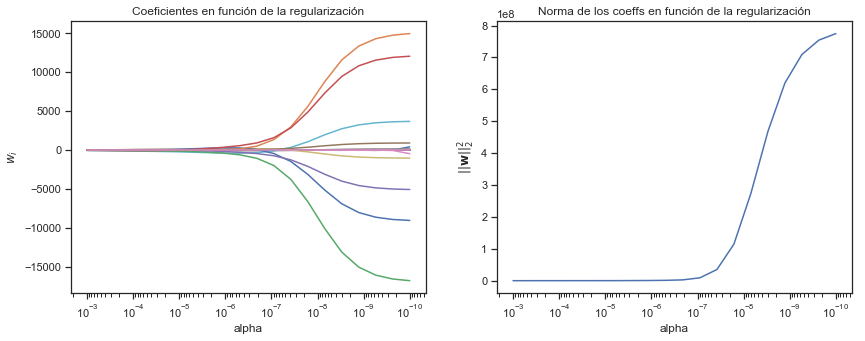

In [113]:
from sklearn.linear_model import Ridge
n_alphas = 20
alphas = np.logspace(-10, -3, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    ridge= Ridge(alpha=a).fit(Xs_train,ys_train)    
    #####
    coefs.append(ridge.coef_)#mete en la lista de coeficintes
    norm2_coefs.append(np.dot(ridge.coef_,ridge.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()



Para responder a este ejercicio de forma correcta debemos probar con distintos valores de $\alpha$ a partir de los datos, pero ¿cómo calculamos este valor? De nuevo, acudimos a la validación cruzada. 

In [182]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alpha_vector = np.logspace(-20,5,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)#neg_mean_squared_error es el mse*(-1)
grid.fit(Xs_train, ys_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']

best mean cross-validation score: -0.081
best parameters: {'alpha': 5.4286754393238595e-09}


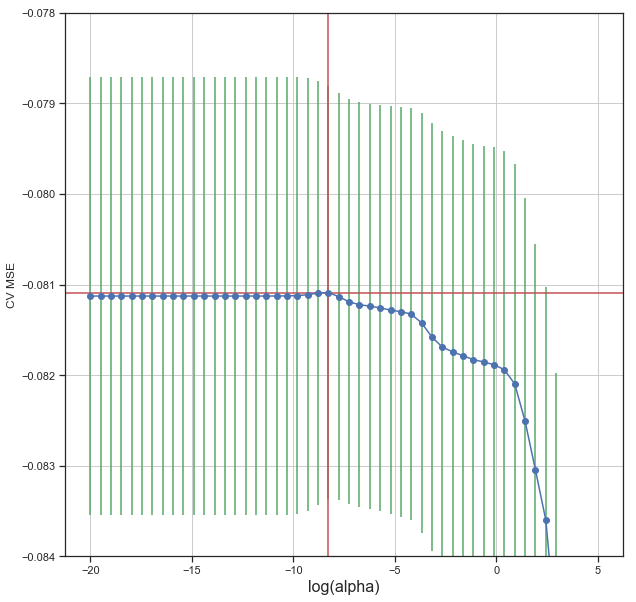

In [183]:
plt.figure(figsize=(10,10))
plt.errorbar(np.log10(alpha_vector),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.axhline(y=grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
plt.axvline(x=np.log10(grid.best_params_['alpha']), color='r')
plt.ylim((-0.084, -0.078))
plt.grid()
plt.show()

Entrenamos el modelo ahora con el valor óptimo de $\alpha$ que hemos encontrado con validación cruzada.

In [184]:
#función para calcular las métricas de regresión
def regression_metrics(ytrainPred,ytestPred):
    MSE_train=np.mean(np.power(ys_train - y_train_predict,2))
    MAE_train=np.mean(np.abs(ys_train - y_train_predict))
    RMSE_train=np.sqrt(MSE_train)
    R2_train=  1 -  sum(np.power(ys_train - y_train_predict,2))/sum(np.power(ys_train - np.mean(y_train_predict),2))
    
    MSE_test=np.mean(np.power(ys_test - ytestPred,2))
    MAE_test=np.mean(np.abs(ys_test - ytestPred))
    RMSE_test=np.sqrt(MSE_test)
    R2_test=  1 -  sum(np.power(ys_test - ytestPred,2))/sum(np.power(ys_test - np.mean(ytestPred),2))

    print('\nMSE training: ', MSE_train)
    print('MAE training:   ', MAE_train)
    print('RMSE training:  ', RMSE_train)
    print('R2 training:    ', R2_train)

    print('\nMSE test: ',MSE_test)
    print('MAE test: ',MAE_test)
    print('RMSE test: ',RMSE_test)
    print('R2 test: ',R2_test)

In [185]:
alpha_optimo = grid.best_params_['alpha']*1000
ridge = Ridge(alpha = alpha_optimo).fit(Xs_train,ys_train)

# predicción
y_train_predict = ridge.predict(Xs_train)
y_hat = ridge.predict(Xs_test)
w = ridge.coef_
norm_w2 = np.dot(w,w.T)

# error
error_test = np.mean(np.power(ys_test - y_hat,2)) 

coef_names = ['w' + str(i) + ': ' for i in range(1,Xs_train.shape[1]+1)]
print('w0: ',ridge.intercept_ )
for f,wi in zip(coef_names,w):
    print(f,wi)
print('error: ',error_test)


regression_metrics(y_train_predict,y_hat)

w0:  -9.174496386608828e-12
w1:  4.336897300293118
w2:  -0.5710344283321735
w3:  0.14891637694548843
w4:  0.22326200094853313
w5:  -0.03609204882935593
w6:  -0.01776459874252559
w7:  4.336836149453098
w8:  -52.73374936759564
w9:  157.17900374740117
w10:  -248.57736705958874
w11:  180.31523290554375
w12:  38.35849500667542
w13:  -167.56164987042337
w14:  95.0585904736064
w15:  1.7811052862560193
w16:  -11.511688941788925
w17:  0.5976027545922519
error:  0.08388236478937079

MSE training:  0.08109842373669734
MAE training:    0.19897783901474475
RMSE training:   0.2847778497999754
R2 training:     0.9189015762633044

MSE test:  0.08388236478937079
MAE test:  0.20215288734098805
RMSE test:  0.2896245238051688
R2 test:  0.9172827918675184


In [153]:
print('Compruebo que obtengo los mismos R2 que con la función de scikit-learn')
print(ridge.score(Xs_train,ys_train))
print(ridge.score(Xs_test,ys_test))

Compruebo que obtengo los mismos R2 que con la función de scikit-learn
0.9191430004428558
0.917079849071102


No hay sobreajuste con Ridge

## 2.1.2 Lasso 

Se refiere al modelo de regresión lineal con penalización (norma 1) sobre la magnitud de los coeficientes

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_1$$

donde $||\boldsymbol{\omega} ||_1 = |\omega_1| + |\omega_2| + \ldots + |\omega_D|$, siendo $D$ el número de atributos ($\omega_0$ no se tiene en cuenta en esta penalización).

Con esta formulación el algoritmo Lasso permite activar/desactivar coeficientes, de tal forma que se desactivan primero los coeficienes asociados a los atributos que menos influyen en la función de coste (función a minimizar anterior). Con ello:

1. Se previene el overfitting, al poder utilizar modelos con menos variables (las desactivamos)
2. Se gana interpretabilidad, al poder ver cómo evolucionan las variables supervivientes.

La activación y desactivación de variables está determinada por el parámetro de regularización $\alpha$, de la misma forma que sucede con el algoritmo Ridge:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

<div class = "alert alert-success">
EJERCICIO: Repite los análisis anteriores (Ridge), para el algoritmo [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
</div>


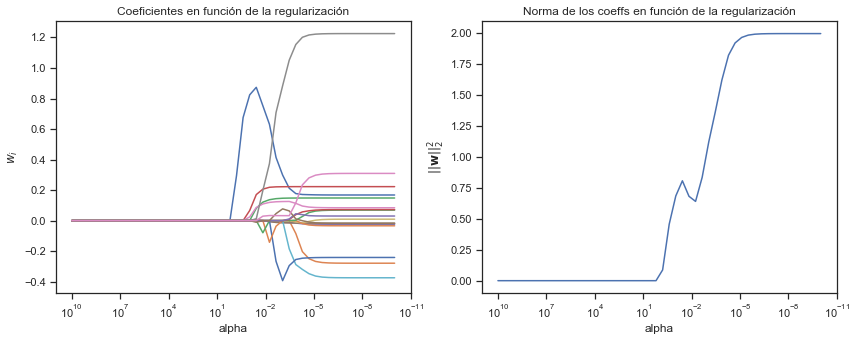

In [60]:
from sklearn.linear_model import Lasso
n_alphas = 50
alphas = np.logspace(-10, 10, n_alphas)
# ...
coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    lasso = Lasso(alpha=a).fit(Xs_train,ys_train)
    #####
    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

In [135]:
alpha_vector = np.logspace(-1000,1,25)
# ...
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(Xs_train, ys_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']

best mean cross-validation score: -0.082
best parameters: {'alpha': 0.0}


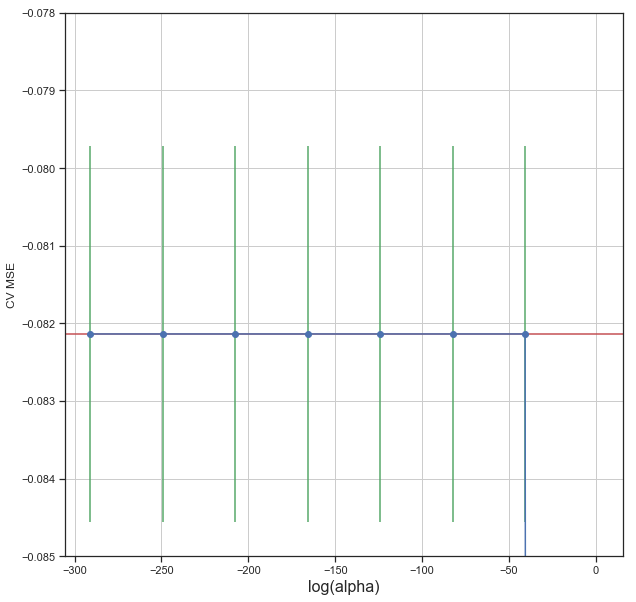

In [136]:
plt.figure(figsize=(10,10))
plt.errorbar(np.log10(alpha_vector),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.axhline(y=grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
plt.axvline(x=np.log10(grid.best_params_['alpha']), color='r')
plt.ylim((-0.085, -0.078))
plt.grid()
plt.show()

In [154]:
alpha_optimo = grid.best_params_['alpha']*1000
lasso = Lasso(alpha = alpha_optimo).fit(Xs_train,ys_train)
# ... 

#ridge = Ridge(alpha = alpha_optimo).fit(X_train,y_train)

# predicción
y_hat = lasso.predict(Xs_test)
y_train_predict=lasso.predict(Xs_train)
w = lasso.coef_
norm_w2 = np.dot(w,w.T)

# error
error_test = np.mean(np.power(ys_test - y_hat,2)) 

coef_names = ['w' + str(i) + ': ' for i in range(1,Xs_train.shape[1]+1)]
print('w0: ',ridge.intercept_ )
for f,wi in zip(coef_names,w):
    print(f,wi)

regression_metrics(y_train_predict,y_hat)

w0:  4.1483097442932794e-10
w1:  0.1677643842609745
w2:  -0.2792267250362374
w3:  0.14809352217774552
w4:  0.22252333694356793
w5:  -0.023959785893505323
w6:  -0.016597242504162404
w7:  0.08415671746270979
w8:  1.2255061875738675
w9:  0.009203509336364069
w10:  -0.37469135014105814
w11:  -0.2415988296366483
w12:  -0.03403744948702664
w13:  0.06856086332244393
w14:  0.07212916912773118
w15:  0.029979287671092196
w16:  -0.018503122749329155
w17:  0.30925828313537573

MSE training:  0.08200169502292028
MAE training:    0.19976134102523885
RMSE training:   0.2863593808886314
R2 training:     0.9179983049770805

MSE test:  0.08479668866114702
MAE test:  0.20319151581397266
RMSE test:  0.2911987099235624
R2 test:  0.9163811681453279


El R2 es ligeramente inferior al conseguido con Ridge pero los coeficientes se prestan para una mejor presentación de cara a business.
Se puede ver que w17: interacción entre carat y clarity tiene una alta importancia a la hora de predecir el precio del diamante y W8: clarity^2 es la variable con el coeficiente más alto 

# 2.2 Boosted trees


Para no extender el entrenamiento, escogeremos de forma muy secuencial los parámetros libres.

AVISO: Este proceso va a tardar un rato ...

In [158]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,1000,1500,2000, 2500, 3000]
learningRate = [0.1,0.05,0.01]
max_depth=range(1,6)
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate,'max_depth': max_depth}
grid = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid=param_grid, cv = 5)
grid.fit(Xs_train, ys_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.983
best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 2500}


In [159]:
bt = GradientBoostingRegressor(random_state=0, max_depth=grid.best_params_['max_depth'],
                               learning_rate= grid.best_params_['learning_rate'], n_estimators= grid.best_params_['n_estimators'])
bt.fit(Xs_train,ys_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2500, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [101]:
from joblib import dump, load
grid= load('2_grid_boosted_tree.joblib')
bt= load('2_bt_boosted_tree.joblib') 

In [ ]:
from joblib import dump, load
dump(grid, '2_grid_boosted_tree.joblib') 
dump(bt, '2_bt_boosted_tree.joblib') 

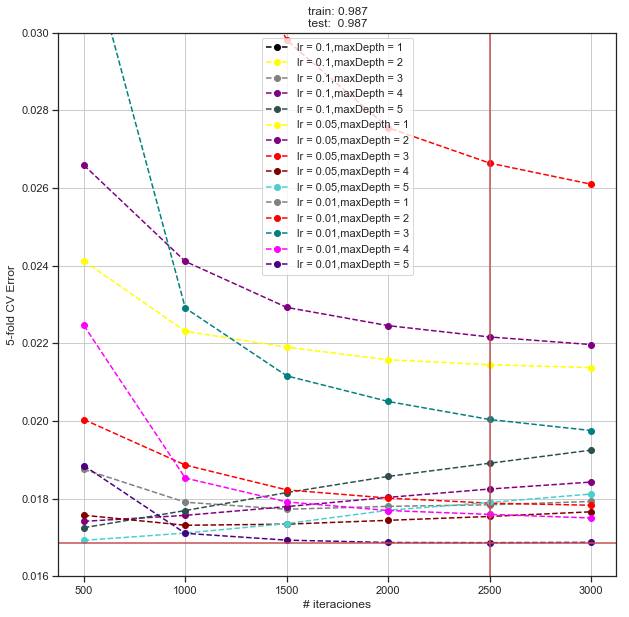

Zoom en la imagen:


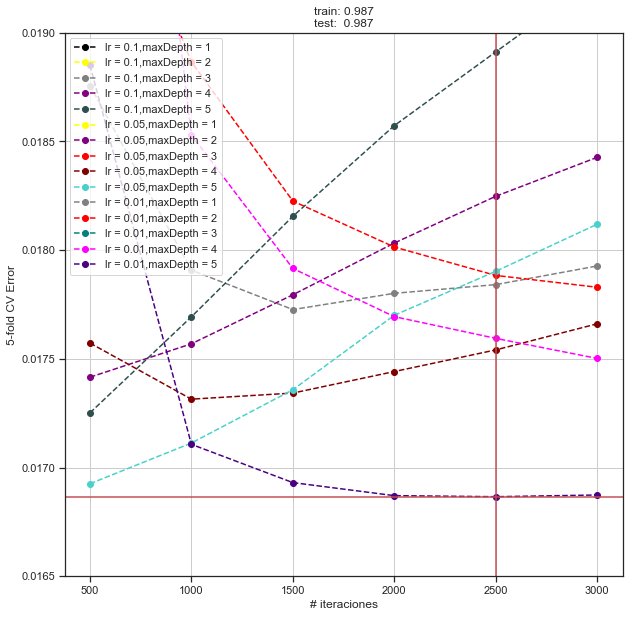

In [200]:
colors = [(0,0,0),	(255,255,0),	(128,128,128),	(128,0,128),	(47,79,79),
(255,0,0),	(0,255,255),	(128,0,0),	(0,128,128),	(72,209,204),
(0,255,0),	(255,0,255),	(128,128,0),	(0,0,128),	(75,0,130),
(0,0,255),	(192,192,192),	(0,128,0),	(50,205,50),	(128,0,128)]
error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(max_depth),len(Niterations))

def draw_lines(ylower,yupper):
    plt.figure(figsize=(10,10))
    for i,lr in enumerate(learningRate):    
        for j in range(0,error[i].shape[0]):
            plt.plot(Niterations,error[i,j,:],color=[x/255.0 for x in colors[(i+1)*(j+1)-1]] , linestyle='--', marker='o',label='lr = %g,maxDepth = %g'%(lr,j+1)  )

    plt.legend()
    plt.xlabel('# iteraciones')
    plt.ylabel('5-fold CV Error')
    plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(Xs_train,ys_train),bt.score(Xs_test,ys_test)))
    plt.axhline(y=1-grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
    plt.axvline(x=grid.best_params_['n_estimators'], color='r')
    plt.ylim((ylower, yupper))
    plt.grid()
    plt.show()

draw_lines(0.016,0.03)
print('Zoom en la imagen:')
draw_lines(0.0165,0.019)


Mirando el último gráfico, la curva (lr, maxDepth)=(0.01,5) no alcanza un mínimo con el mayor número de iteraciones. Sería más conveniente escoger la curva (0.01,4) que tiene su valor mínimo con 3000 iteraciones (línea rosa) aunque no tenga el error menor pero se ve que decrece lenta y consistentemente a diferencia de las demás curvas.

De todos modos, afinaré mejor la búsqueda aumentando las iteraciones y excluyendo el learning rate más alto. También excluiré profundidad 1:

In [203]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [1000,3000,5000,7000,10000]
learningRate = [0.05,0.01]
max_depth=range(2,6)
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate,'max_depth': max_depth}
grid = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid=param_grid, cv = 5)
grid.fit(Xs_train, ys_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

bt = GradientBoostingRegressor(random_state=0, max_depth=grid.best_params_['max_depth'],
                               learning_rate= grid.best_params_['learning_rate'], n_estimators= grid.best_params_['n_estimators'])
bt.fit(Xs_train,ys_train)
from joblib import dump, load
dump(grid, '2_grid_boosted_treev2.joblib') 
dump(bt, '2_bt_boosted_treev2.joblib') 

best mean cross-validation score: 0.983
best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 3000}


['2_bt_boosted_treev2.joblib']

In [165]:
from joblib import dump, load
grid=load('2_grid_boosted_treev2.joblib') 
bt=load('2_bt_boosted_treev2.joblib') 

In [172]:
grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(max_depth),len(Niterations))

array([[[0.97589004, 0.97803174, 0.97856621, 0.97866829, 0.9786807 ],
        [0.9811344 , 0.98217061, 0.98204925, 0.98186747, 0.98159757],
        [0.98268536, 0.98233879, 0.9819069 , 0.98150171, 0.9809495 ],
        [0.98288708, 0.98188081, 0.98114538, 0.98059688, 0.97994646]],

       [[0.96463446, 0.9739012 , 0.97576194, 0.97686557, 0.97751757],
        [0.97709022, 0.98024621, 0.98100357, 0.9815861 , 0.98197115],
        [0.98146964, 0.98249806, 0.98266296, 0.98266839, 0.98261143],
        [0.98289311, 0.98312606, 0.9829895 , 0.98281507, 0.98252338]]])

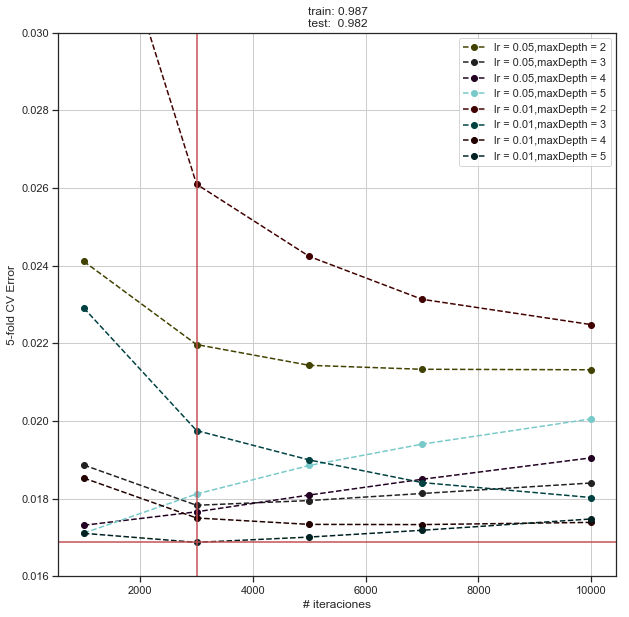

Zoom en la imagen:


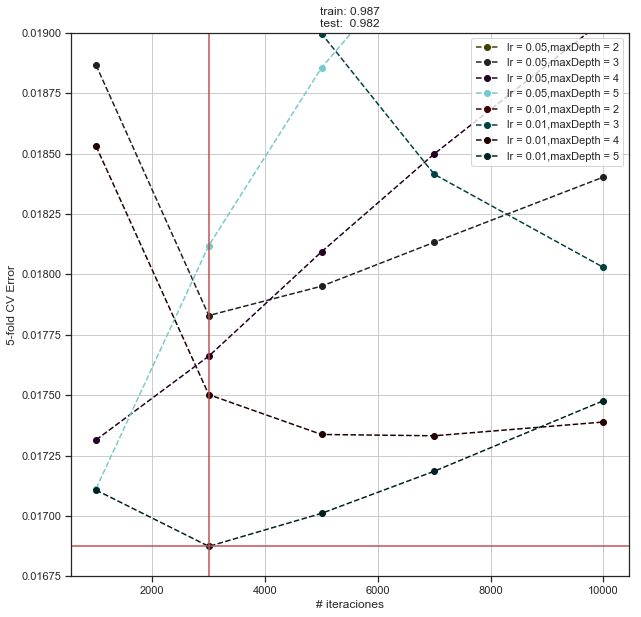

In [179]:
colors = [(0.255,0.255,0),	(0.128,0.128,0.128),	(0.128,0,0.128),	(0.47,0.79,0.79),
(0.255,0,0),	(0,0.255,0.255),	(0.128,0,0),	(0,0.128,0.128),	(0.72,0.209,0.204),
(0,0.255,0),	(0.255,0,0.255),	(0.128,0.128,0),	(0,0,0.128),	(0.75,0,0.130),
(0,0,0.255),	(0.192,0.192,0.192),	(0,0.128,0),	(0.50,0.205,0.50),	(0.128,0,0.128),(0,0,0)]


error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(max_depth),len(Niterations))

def draw_lines_v2(ylower,yupper):
    icolor=0
    plt.figure(figsize=(10,10))
    for i,lr in enumerate(learningRate):    
        for j in range(0,error[i].shape[0]):
            plt.plot(Niterations,error[i,j,:],color=colors[icolor] , linestyle='--', marker='o',label='lr = %g,maxDepth = %g'%(lr,j+2)  )
            icolor=icolor+1

    plt.legend()
    plt.xlabel('# iteraciones')
    plt.ylabel('5-fold CV Error')
    plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(Xs_train,ys_train),bt.score(Xs_test,ys_test)))
    plt.axhline(y=1-grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
    plt.axvline(x=grid.best_params_['n_estimators'], color='r')
    plt.ylim((ylower, yupper))
    plt.grid()
    plt.show()

draw_lines_v2(0.016,0.03)
print('Zoom en la imagen:')
draw_lines_v2(0.01675,0.019)

Esta vez el error más bajo se encuentra en la curva (lr,maxDepth)=(0.01,5) con 3000 iteraciones pero de nuevo la curva empieza a subir inmediatamente después por lo cual no es una buena opción. La mejor opción está en la curva (0.01,3) que tiene mínimo en 10000 iteraciones con 0.1802 de error.

### Importancia y dependencia

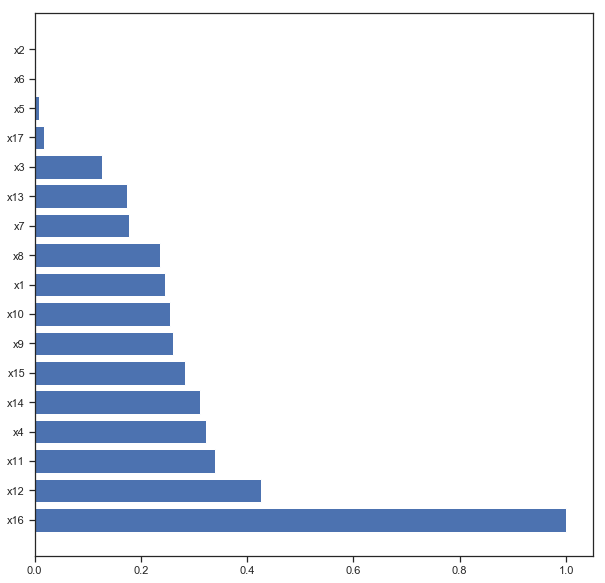

In [174]:
#feature_names = data.columns[1:]
feature_names =np.array(['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17'])
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(Xs_train.shape[1]),importances[indices])
plt.yticks(range(Xs_train.shape[1]),feature_names[indices])
plt.show()
## La variable más importante resulta ser x16: carat^2.
## De las variables originales más importantes, en 4 lugar tenemos clarity mientras que las demás
## están a la cola. 
## Las variables del polinomio en los órdenes 7 y 6, x12 y x11,también están entre las más importantes


Por último, representemos los conocidos como *partial dependence plots*:

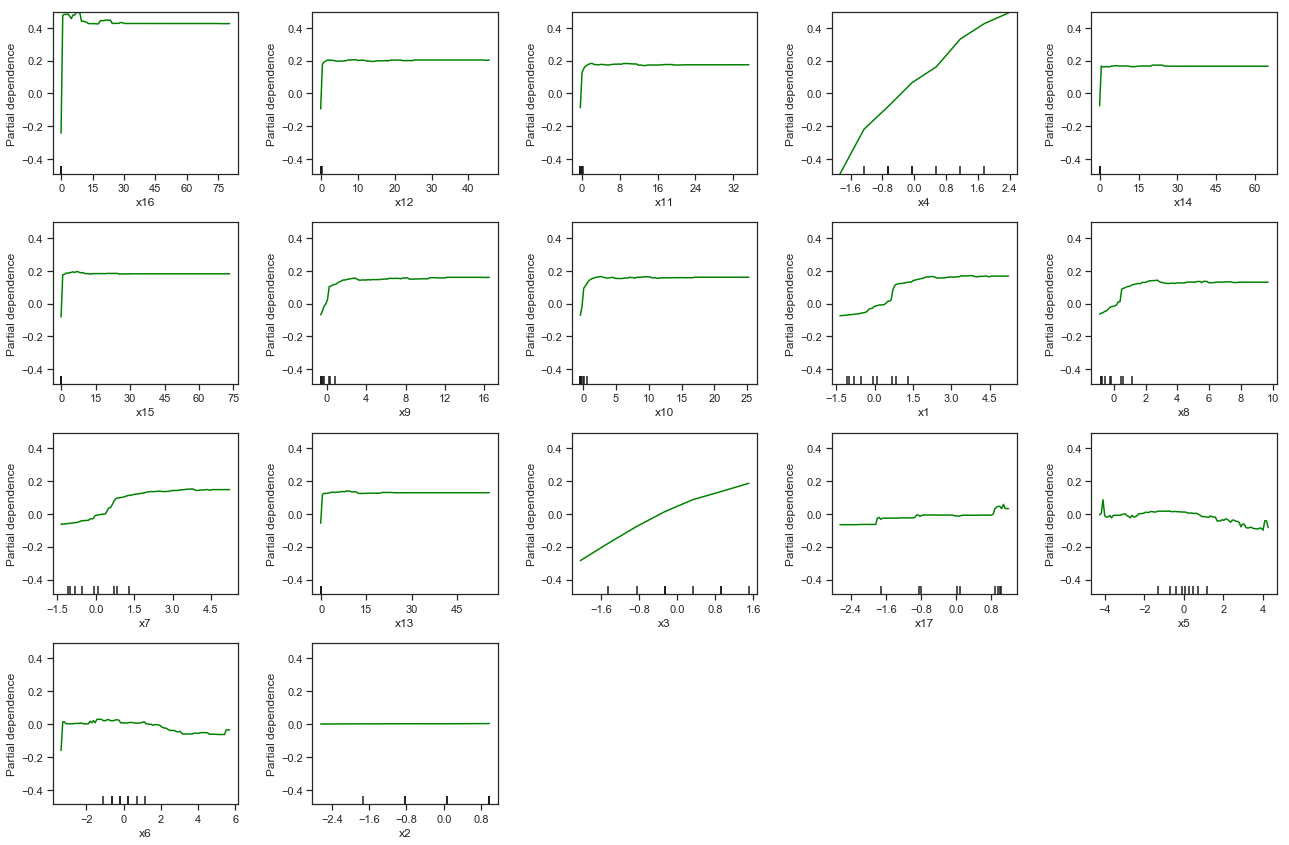

In [175]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, ax = plot_partial_dependence(bt, Xs_train, indices, feature_names=feature_names,
                                 percentiles=(0.0, 1.0), n_cols = 5)
fig.set_size_inches(20, 20)
plt.show()

# En los gráficos se puede apreciar como varía el precio cuando varían las variables explicativas. 
# En las variables x4: clarity se puede confirmar la importancia de la variable ya que con un incremento 
# de x4 sube proporcionalmente el precio. También se puede apreciar con x3.  

In [176]:
y_train_predict=bt.predict(Xs_train)
y_hat=bt.predict(Xs_test)
regression_metrics(y_train_predict,y_hat)


MSE training:  0.012514480790006543
MAE training:    0.06628125313449791
RMSE training:   0.11186814019195342
R2 training:     0.9874855192099937

MSE test:  0.01848256655511798
MAE test:  0.07705458323510331
RMSE test:  0.1359506033643028
R2 test:  0.9817741707669334


## 2.4 SVM en regresión

Volvemos a nuestro conjunto de datos ya conocido:

La siguiente celda tarda en ejecutarse varias horas.

In [35]:
from sklearn.svm import SVR
# Paso 2:
vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(Xs_train, ys_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 850.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02]), 'gamma': array([1.00000e-05, 7.19686e-05, 5.17947e-04, 3.72759e-03, 2.68270e-02,
       1.93070e-01, 1.38950e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [36]:
from joblib import dump, load
dump(grid, '2_svm_reg.joblib') 

['2_svm_reg.joblib']

best mean cross-validation score: 0.979
best parameters: {'C': 100.0, 'gamma': 0.026826957952797246}


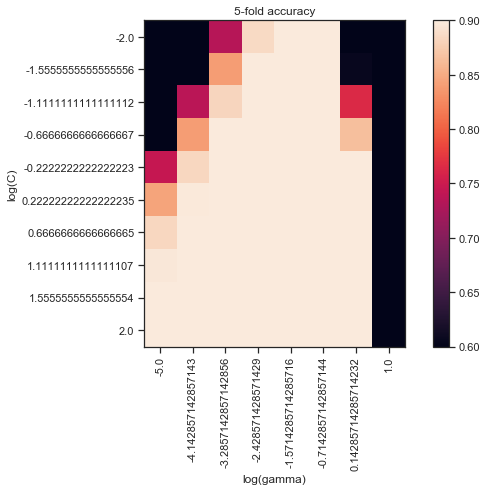

In [37]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

In [38]:
# Paso 3:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(Xs_train,ys_train)


In [155]:
y_train_predict=svmModel.predict(Xs_train)
y_hat=svmModel.predict(Xs_test)
regression_metrics(y_train_predict,y_hat)


MSE training:  0.017706580346684053
MAE training:    0.08253784444501555
RMSE training:   0.1330660751156509
R2 training:     0.982294488812766

MSE test:  0.023038765796378324
MAE test:  0.08919338933737729
RMSE test:  0.15178526211848872
R2 test:  0.977282888163273


In [157]:
print('Los valores de svmModel.score coinciden con los calculados a mano')
print('Acc (TEST): %0.3f'%svmModel.score(Xs_train,ys_train))
print('Acc (TEST): %0.3f'%svmModel.score(Xs_test,ys_test))

Los valores de svmModel.score coinciden con los calculados a mano
Acc (TEST): 0.982
Acc (TEST): 0.977


Mirando el gráfico, la combinación de valores de c y gamma elegida ha sido correcta ya que tenemos un área bastante amplia que indica que estamos en el 90%. 

Este problema es suficientemente complejo como para ser analizado en una [tesis de máster](http://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=1540&context=etd_projects).

# 3. Otros métodos Kernel

## 3.1 Kernel Ridge Regression

Vemos un ejemplo sencilo de [Kernel Ridge Regression](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge). En este caso no es necesario que utilicemos un modelo de datos de alta dimensionalidad, basta elegir adecuadamente los parámetros libres.

In [189]:
from sklearn.kernel_ridge import KernelRidge

# definimos modelo
kRidge = KernelRidge(kernel='rbf',gamma=5,alpha=alpha_optimo)
kRidge.fit(Xs_train,ys_train)

# predicción
y_hat = kRidge.predict(Xs_test)

In [41]:
from joblib import dump, load
dump(grid, '2_krr_reg.joblib') 

['2_krr_reg.joblib']

In [190]:
y_train_predict=kRidge.predict(Xs_train)
y_hat=kRidge.predict(Xs_test)
regression_metrics(y_train_predict,y_hat)


MSE training:  0.0003274418415168134
MAE training:    0.007178036112977998
RMSE training:   0.018095354141790466
R2 training:     0.9996725581584833

MSE test:  0.43884826579874797
MAE test:  0.32789567600425573
RMSE test:  0.6624562368932366
R2 test:  0.5713478414030911


Para ridge regression utilicé el alpha óptimo utilizado con la regresión ridge en el punto 2.1 y con valores de gamma=[1,5,10] obtengo un R2 de test de 57% como máximo con lo cual es un modelo sobreajustado.

Conclusión: El mejor algoritmo es boosted trees que supera por muy poco a SVM en regresión con 0.9874 vs 9822 en training y 0.9817 vs 0.977 en test. Al mismo tiempo podemos apreciar que no existe overfitting.
Los modelos de ridge y lasso se quedan detrás con un R2 cercano al 91% sin sobreajuste.

Otro punto a destacar es la diferencia de los algoritmos a la hora de señalar las variables importantes. Por ejemplo en Lasso las variables más importantes son clarity y la interacción entre carat y clarity, mientras que en boosted tree las variables más importantes son carat^10, carat^7 y carat^6.